# Adaptive RAG: Enhancing Information Retrieval with Dynamic Decision-Making





Adaptive RAG (Retrieval-Augmented Generation) introduces a sophisticated approach to information retrieval by dynamically deciding when to retrieve external knowledge. This method balances internal and external knowledge, ensuring that responses are both accurate and relevant. By utilizing confidence scores from the language model's internal states, Adaptive RAG assesses the necessity of retrieval, while an honesty probe helps avoid hallucinations by aligning outputs with actual knowledge. This system reduces unnecessary retrievals, improving both efficiency and response accuracy.



## Key Features of Adaptive RAG



- **Dynamic Retrieval Decisions**: The system intelligently determines when to access external knowledge based on the context and complexity of the query.

- **Confidence Scoring**: Utilizes confidence scores derived from the language model’s internal states to evaluate whether additional information is needed for a given response.

- **Honesty Probe**: Implements mechanisms to ensure outputs align with the model's actual knowledge, reducing the risk of generating misleading or incorrect information.

- **Efficiency Improvement**: Reduces unnecessary retrievals, leading to faster response times and lower computational costs.


## How Adaptive RAG Works



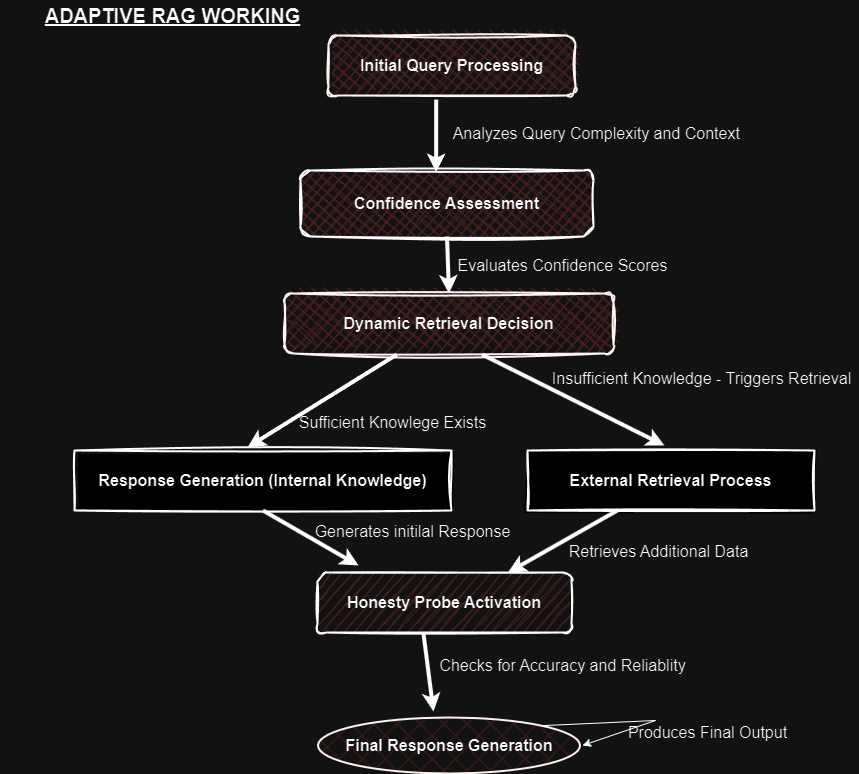

1. **Initial Query Processing**: When a user submits a query, the system first analyzes it to determine its complexity and context.

2. **Confidence Assessment**: The language model evaluates its internal states and generates confidence scores related to the query's answerability based on its existing knowledge.

3. **Dynamic Retrieval Decision**:
   - If confidence scores indicate sufficient knowledge exists internally, the model generates a response without external retrieval.
   - If scores suggest uncertainty or lack of information, the model triggers an external retrieval process to gather additional data.

4. **Honesty Probe Activation**: Before finalizing responses, an honesty probe checks for alignment with known facts and prior outputs to ensure accuracy and reliability.

5. **Final Response Generation**: The model synthesizes a final response based on either internal knowledge or retrieved external information, ensuring it is contextually relevant and accurate.



In [ ]:
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Step 0: Set up the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 1: Download and Read the PDF
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 2: Preprocess Text into Chunks
chunk_size = 1000
chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
print(f"Number of chunks created: {len(chunks)}")

Number of chunks created: 65


In [ ]:
# Step 3: Initial Query Processing - Analyze User Query
user_query = "comparison between BERT and OpenAI GPT?"

In [ ]:
def analyze_query(query):
    try:
        analysis_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a query analysis assistant."},
                {"role": "user", "content": f"Analyze the complexity and context of this query:\n\n{query}"},
            ],
            model="llama3-8b-8192",
        )
        return analysis_response.choices[0].message.content
    except Exception as e:
        print(f"Error during query analysis: {e}")
        return None

In [ ]:
query_analysis = analyze_query(user_query)

In [ ]:
# Step 4: Confidence Assessment - Evaluate Internal Knowledge
def assess_confidence(query):
    try:
        confidence_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a confidence assessment assistant."},
                {"role": "user", "content": f"Evaluate your confidence in answering this query:\n\n{query}"},
            ],
            model="llama3-8b-8192",
        )
        return confidence_response.choices[0].message.content
    except Exception as e:
        print(f"Error during confidence assessment: {e}")
        return None

In [ ]:
confidence_score = assess_confidence(user_query)

In [ ]:
# Step 5: Dynamic Retrieval Decision - Determine Retrieval Strategy
def decide_retrieval(confidence):
    if "sufficient knowledge" in confidence:
        return False  # No external retrieval needed
    else:
        return True  # External retrieval needed

In [ ]:
needs_retrieval = decide_retrieval(confidence_score)

In [ ]:
# Step 6: Document Retrieval if Needed
def retrieve_documents(query):
    vectorizer = TfidfVectorizer()
    query_embedding = vectorizer.fit_transform([query])
    chunk_embeddings = vectorizer.transform(chunks)

    similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()
    top_k_indices = similarities.argsort()[-3:][::-1]  # Get top 3 relevant chunks
    return [chunks[i] for i in top_k_indices]

In [ ]:
retrieved_documents = retrieve_documents(user_query) if needs_retrieval else []

In [ ]:
# Step 7: Generate Initial Response Based on Internal Knowledge or Retrieved Documents
def generate_initial_response(context):
    try:
        response_generation = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a response generation assistant."},
                {"role": "user", "content": f"Generate a response based on the following context:\n\n{context}"},
            ],
            model="llama3-8b-8192",
        )
        return response_generation.choices[0].message.content
    except Exception as e:
        print(f"Error during initial response generation: {e}")
        return None

In [ ]:
# Generate initial response based on internal knowledge or retrieved documents
if not needs_retrieval:
    initial_response = generate_initial_response(user_query)  # Generate based on user query directly
else:
    context = "\n\n".join(retrieved_documents)
    initial_response = generate_initial_response(context)  # Generate response based on retrieved documents

In [ ]:
# Step 8: Honesty Probe Activation - Check for Alignment with Known Facts
def honesty_probe(response):
    try:
        honesty_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an honesty probe assistant."},
                {"role": "user", "content": f"Check the following response for alignment with known facts:\n\n{response}"},
            ],
            model="llama3-8b-8192",
        )
        return honesty_response.choices[0].message.content
    except Exception as e:
        print(f"Error during honesty probe: {e}")
        return None

In [ ]:
honesty_feedback = honesty_probe(initial_response)

In [ ]:
# Step 9: Final Response Generation - Synthesize Final Output
def generate_final_response(initial, retrieved):
    context = initial + "\n\n" + "\n".join(retrieved)
    try:
        final_response_generation = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a final response generation assistant."},
                {"role": "user", "content": f"Generate a final response based on the following context:\n\n{context}"},
            ],
            model="llama3-8b-8192",
        )
        return final_response_generation.choices[0].message.content
    except Exception as e:
        print(f"Error during final response generation: {e}")
        return None

In [ ]:
final_output = generate_final_response(initial_response, retrieved_documents)

In [ ]:
# Step 10: Deliver the Final Response
if final_output:
    print("\n--- Final Output ---\n")
    print(final_output)
else:
    print("No valid final output generated.")


--- Final Output ---

Here is a potential final response based on the given context:

In conclusion, the empirical improvements of the BERT model over OpenAI GPT can be attributed to the bi-directionality and two pre-training tasks. The design decisions made in BERT aimed to make the model as close to GPT as possible to enable minimal comparison between the two pre-training methods. The key differences between the two models lie in the training data and architecture. BERT is trained on a large corpus of text from both BooksCorpus and Wikipedia, whereas OpenAI GPT is trained exclusively on the BooksCorpus.

The use of bidirectional Transformer architecture and joint fine-tuning approach in BERT allows it to capture more contextual information and achieve better performance than OpenAI GPT. The Next Sentence Prediction task is another significant aspect of the BERT pre-training objective, which provides context for the next sentence prediction. The differences in architecture and traini

### Code Breakdown: User Query Processing and Response Generation

This Python script performs several tasks for handling a user query, including document retrieval, response generation, and final output synthesis. Below is the step-by-step breakdown:

### Step 1: Groq Client Setup
- Initializes the Groq client using an API key.
- This client will handle interactions such as generating responses and checking confidence.

### Step 2: Download and Read PDF
- The script downloads a PDF (e.g., BERT paper from arXiv) using the `requests` library and saves it locally as `BERT_paper.pdf`.
- The `PyPDF2` library reads the PDF file, extracting text from each page and concatenating them into a single string.

### Step 3: Preprocess Text into Chunks
- The extracted text is split into chunks (of 1000 characters each).
- This helps break the text into manageable parts for better retrieval.

### Step 4: Analyze User Query
- Sends the user query to Groq to analyze its complexity and context.
- Determines if the query is straightforward or requires more nuanced handling.

### Step 5: Assess Confidence
- Evaluates the system’s confidence in answering the query.
- If confidence is low, the system triggers external retrieval of relevant documents.

### Step 6: Decide Retrieval Strategy
- Based on the confidence score, the system determines whether it can answer the query using its internal knowledge or needs additional information from external sources.

### Step 7: Document Retrieval
- If needed, the system uses `TfidfVectorizer` to compute cosine similarity between the user query and chunks of the PDF.
- Retrieves the top 3 most relevant text chunks.

### Step 8: Generate Initial Response
- Generates an initial response based on internal knowledge (if no retrieval needed) or retrieved documents (if retrieval is needed).

### Step 9: Honesty Probe
- A "honesty probe" is conducted to check if the generated response aligns with known facts and is truthful.

### Step 10: Final Response Generation
- If the honesty probe is positive, the system synthesizes a final response combining the initial response and the relevant document chunks.

### Final Output
- The final response is printed if everything goes well.
- If any step fails, an error message is displayed.



## Applications of Adaptive RAG



- **Customer Service Automation**: Provides timely and accurate responses to customer inquiries by dynamically accessing relevant information as needed.

- **Research Support Tools**: Assists researchers in obtaining precise data while minimizing unnecessary searches through effective context evaluation.

- **Content Generation Systems**: Enhances content creation processes by ensuring that generated materials are factually accurate and relevant to current topics.

- **Educational Platforms**: Supports learning applications by delivering reliable information tailored to student queries in real-time.




## Advantages of Adaptive RAG



- **Increased Accuracy**: By relying on confidence scores and prior knowledge, Adaptive RAG enhances the accuracy of responses, minimizing errors.

- **Efficiency Gains**: The ability to avoid unnecessary retrievals streamlines the information retrieval process, saving time and resources.

- **Contextual Relevance**: Dynamic decision-making ensures that responses are tailored to the specific context of each query, improving user satisfaction.

- **Reduced Hallucinations**: The honesty probe helps maintain factual integrity in responses, reducing instances of hallucinated information.



## Limitations of Adaptive RAG



- **Complexity in Implementation**: The dynamic nature of retrieval decisions can complicate system design and require sophisticated algorithms for effective operation.

- **Resource Requirements**: While it improves efficiency, the system may still demand significant computational resources for processing complex queries.

- **Dependence on Model Confidence**: The effectiveness of Adaptive RAG is contingent on the accuracy of the model's confidence scoring; inaccurate assessments can lead to suboptimal retrieval decisions.



## Conclusion



Adaptive RAG represents a significant advancement in retrieval-augmented generation methodologies by introducing dynamic decision-making capabilities. By balancing internal knowledge with external retrieval needs, it enhances both accuracy and efficiency in information retrieval processes. As organizations increasingly rely on AI-driven solutions for complex queries, Adaptive RAG stands out as a powerful tool for delivering precise and contextually relevant responses.



Having explored Adaptive RAG, we will now move on to REFEED (Retrieval Feedback).